In [1]:
# importation des bibliothèques
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
import itertools
import os
import time

In [2]:
# initialiser learning rate, number of epochs to train for, et batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
PATH = "dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
# lire les images et leurs catégories
imagePaths = list(paths.list_images(PATH))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[1]
    image = load_img(imagePath, color_mode='rgb', target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)
    
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
# one-hot encoding pour les labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
# partitionner les données en fractionnements d'entraînement et de test en utilisant 80% de
# les données pour le Train et les 20% restants pour le Test
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

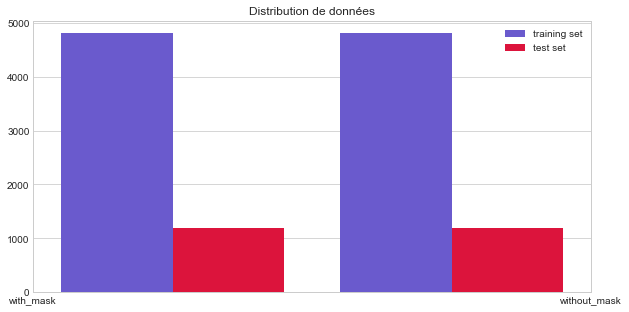

In [8]:
# tracer la distrubution de données entre "training" et "test" 
plt.figure(figsize=(10,5))
plt.style.use('seaborn-whitegrid')
plt.hist([y_train,y_test],bins=2, label=['training set', 'test set'], color=['slateblue', 'crimson'])
plt.xticks([0,1], CATEGORIES)
plt.title("Distribution de données")
plt.legend()
plt.savefig(r"plot\Distribution.png")
plt.show()

In [7]:
# inisialiser un générateur pour augmentation des données
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
)

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
img = np.expand_dims(plt.imread(imagePath),0)
aug_iter = aug.flow(img)
aug_img = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

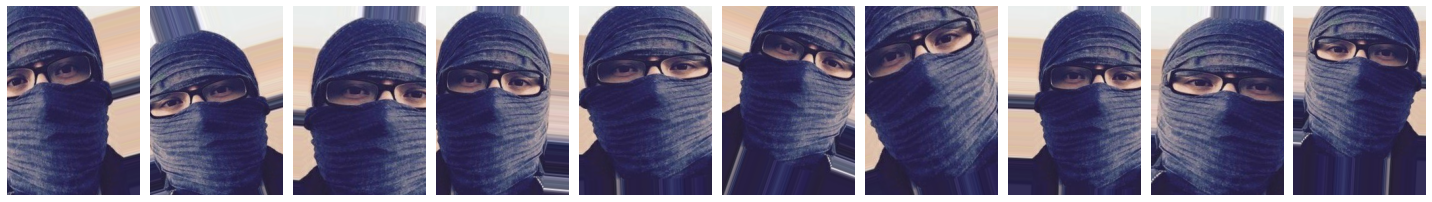

In [12]:
#plotImages(aug_img)

In [8]:
# charger le réseau mobilenetve2, en veillant à ce que les ensembles de couches FC de tête soit désactivés
input_tensor = Input(shape=(224, 224, 3))
basemodel = MobileNetV2(input_tensor=input_tensor, weights="imagenet", include_top=False)

In [9]:
# construire la tête du modèle qui sera placée au-dessus du modèle de base
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(7,7))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headModel = Dropout(0.5)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

In [10]:
# placez le modèle FC de tête sur le modèle de base
model = Model(inputs=basemodel.input, outputs=headmodel)

In [15]:
basemodel.summary()
print("Number of layers in basemodel : ",len(basemodel.layers))

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
model.summary()
print("Number of layers in model : ",len(model.layers))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [12]:
# boucle sur tous les layers de basemodel et "freeze" tous ces layers 
# pour qu'elles ne soient pas mises à jour lors du processus de training
for layer in basemodel.layers:
    layer.trainable = False

In [13]:
# enregistrer le meilleur modèle
checkpoint = ModelCheckpoint(filepath=r"model\best_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [14]:
# visualisation du modèle
name = r"logs\with_mask_VS_without_mask_{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir=name, histogram_freq=1)

In [15]:
# compiler le modèle
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=['accuracy'])

In [16]:
# entrainer "head" du réseau de neurones
head = model.fit(
    aug.flow(x_train, y_train, batch_size=BS, shuffle=True),
    steps_per_epoch = len(x_train) // BS,
    validation_data = (x_test, y_test),
    validation_steps = len(x_test) // BS,
    callbacks=[checkpoint, tensorboard],
    epochs = EPOCHS
)

Epoch 1/20
150/150 [==============================] - 368s 2s/step - loss: 0.3448 - accuracy: 0.8836 - val_loss: 0.1111 - val_accuracy: 0.9675

Epoch 00001: val_accuracy improved from -inf to 0.96750, saving model to model\best_model.hdf5
Epoch 2/20
150/150 [==============================] - 145s 963ms/step - loss: 0.0921 - accuracy: 0.9731 - val_loss: 0.0861 - val_accuracy: 0.9733

Epoch 00002: val_accuracy improved from 0.96750 to 0.97333, saving model to model\best_model.hdf5
Epoch 3/20
150/150 [==============================] - 146s 975ms/step - loss: 0.0666 - accuracy: 0.9791 - val_loss: 0.0764 - val_accuracy: 0.9800

Epoch 00003: val_accuracy improved from 0.97333 to 0.98000, saving model to model\best_model.hdf5
Epoch 4/20
150/150 [==============================] - 144s 961ms/step - loss: 0.0685 - accuracy: 0.9794 - val_loss: 0.0710 - val_accuracy: 0.9800

Epoch 00004: val_accuracy did not improve from 0.98000
Epoch 5/20
150/150 [==============================] - 145s 963ms/step

In [17]:
if os.path.isfile(r"model\mask_model.h5") is False :
    model.save(r"model\mask_model.h5", save_format='h5')

In [24]:
model = load_model(r"model\best_model.hdf5")

In [25]:
# faire des prédictions sur les données du test
predire = model.predict(x_test, batch_size=BS)
predire = np.argmax(predire, axis=1)

In [26]:
y_true = y_test.argmax(axis=1)

In [27]:
cm = confusion_matrix(y_true=y_true, y_pred=predire)

In [28]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Matrice de confusion',
                        cmap=plt.cm.Purples):
    plt.figure(figsize=(10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize='x-large',
            color="white" if cm[i, j] > cm.mean() else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(r"plot\Matrice de confusion.png")    

[[593   7]
 [ 14 586]]


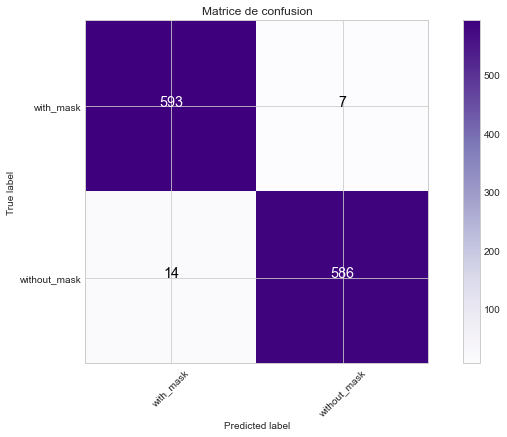

In [29]:
plot_confusion_matrix(cm=cm, classes=CATEGORIES, title='Matrice de confusion')

In [30]:
print(classification_report(y_true=y_true, y_pred=predire, target_names=CATEGORIES))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       600
without_mask       0.99      0.98      0.98       600

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [31]:
model.evaluate(x_test, y_test)

38/38 [==============================] - 39s 994ms/step - loss: 0.0553 - accuracy: 0.9825


[0.055341143161058426, 0.9825000166893005]